In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import random

In [2]:
#threshold comparison to classify data

def stump_classify(data_matrix, dim, splitvalue, splitineq): 
    filter_array = np.ones((np.shape(data_matrix)[0],1))
    if splitineq == 'below':
       filter_array[data_matrix[:,dim] <= splitvalue] = -1
    else:
       filter_array[data_matrix[:,dim] > splitvalue] = -1
    return filter_array

In [3]:
#finding the best decision stump for our dataset

def decision_stump(data_array, labelset, D): 
    data_matrix = np.mat(data_array)
    labelset = np.mat(labelset).T
    row,col_len = np.shape(data_matrix)
    iterations = 25
    stumps = {}
    best_class = np.ones((row,1))
    min_error = np.inf
    for i in range(col_len):
        minvalue = data_matrix[:,i].min()
        maxvalue = data_matrix[:,i].max()
        step_size = (maxvalue - minvalue)/iterations
        for j in range(0, iterations):
            for inequal in ['below', 'above']:
                splitvalue = (minvalue + j * step_size)
                prediction_values = stump_classify(data_matrix,i,splitvalue,inequal)
                error_array = np.ones((row,1))
                error_array[prediction_values == labelset] = 0
                weighted_error = D.T * error_array

                if weighted_error < min_error:
                   min_error = weighted_error
                   best_class = prediction_values.copy()
                   stumps['dimension'] = i
                   stumps['split'] = splitvalue
                   stumps['ineq'] = inequal
                  
    return stumps,min_error,best_class

In [4]:
#based on the decision_stump we build, we start implementing the full AdaBoost

def adaboost_training(data_array,labelset,n_iterations= 40):
    weak_learners = []
    row_len = np.shape(data_array)[0]
    D = np.mat(np.ones((row_len,1))/row_len)
    agg_class_est = np.mat(np.zeros((row_len,1)))
    for i in range(n_iterations):
        stumps,error,class_est = decision_stump(data_array, labelset, D)
        alpha = float(0.5*np.log((1.0-error)/max(error,1e-16))) 
        stumps['alpha'] = alpha
        weak_learners.append(stumps)
        expon = np.multiply(-1*alpha*np.mat(labelset).T,class_est)
        D = np.multiply(D,np.exp(expon))
        D = D/D.sum()
        agg_class_est += alpha*class_est
        
        aggErrors = np.multiply(np.sign(agg_class_est) !=
                    np.mat(labelset).T,np.ones((row_len,1)))
        errorRate = aggErrors.sum()/row_len
        

        if errorRate == 0.0: break
    return weak_learners,agg_class_est 

In [5]:
#we have an array of weak leaners + alpha value for each classifier. now we just need to take the train of weak classifiers from the training function and
#apply these to an instance

def adaboost_classifier(classification_data,classifier_array): 
    data_matrix = np.mat(classification_data) 
    row_len = np.shape(data_matrix)[0] 
    agg_class_est = np.mat(np.zeros((row_len,1))) 
    for i in range(len(classifier_array)):
        class_est = stump_classify(data_matrix,classifier_array[i]['dimension'],\
                                classifier_array[i]['split'],\
                                classifier_array[i]['ineq'])
        agg_class_est += classifier_array[i]['alpha']*class_est
        
    return (agg_class_est)

In [6]:
#test_train split based on the required parameters.

def split_train_test(df,test_size,label_col,random_state=50):

    random.seed(random_state)
    
    
    label_col = str(label_col)
    dat_len  = len(df)
    X= df.drop(columns=label_col)
    Y = df[label_col]
  
    
    
    if isinstance(test_size,float):
        test_size = round(test_size*dat_len)
        
    indices = list(data.index)
    test_indices = random.sample(population=indices, k=test_size)
    
    X_train = X.drop(test_indices)
    x_test  = X.loc[test_indices]
   
    Y_train= Y.drop(test_indices)
    y_test = Y.loc[test_indices]
   
    
    return X_train.sample(frac=1,random_state=random_state),x_test,Y_train.sample(frac=1,random_state=random_state),y_test

In [7]:
#since we have 7 classes in the dataset, we need to extent our solution to multi class. this function implements multi-class
#external cross-validation.

def multi_class_adaboost(data,k_folds,T_rounds,labelset,random_state):
    
    random.seed(random_state)
    
    X_train,x_test,Y_train,y_test = split_train_test(data,test_size=0.2,label_col=labelset,random_state=random_state)
    indices = np.array_split(list(X_train.index),k_folds)

    Cv_test_acc = np.mat(np.ones(shape=(len(T_rounds),k_folds)))
    Cv_train_acc = np.mat(np.ones(shape=(len(T_rounds),k_folds)))

    for T in T_rounds:
        for k in range(k_folds):
            train_preds= np.mat(np.ones(shape=(np.shape(X_train.drop(indices[k]))[0],len(np.unique(data[labelset])))))
            test_preds = np.mat(np.ones(shape=(np.shape(indices[k])[0],len(np.unique(data[labelset])))))
            for classes in range(len(np.unique(data[labelset]))):
                model,pred = adaboost_training(X_train.drop(indices[k]),np.where(Y_train.drop(indices[k])==classes+1,1,-1),T)
                train_preds[:,classes]=np.multiply(train_preds[:,classes],pred)
                test_est = adaboost_classifier(X_train.loc[indices[k]],model)
                test_preds[:,classes] = np.multiply(test_preds[:,classes],test_est)

            train_predictions = np.argmax(train_preds,axis=1)+1
            training_error =np.where(train_predictions!=np.mat(Y_train.drop(indices[k])).T,1,0).sum()
            Cv_train_acc[T_rounds.index(T),k]=1-(training_error/len(train_predictions))
            test_prediction = np.argmax(test_preds,axis=1)+1
            test_error = np.where(test_prediction!=np.mat(Y_train.loc[indices[k]]).T,1,0).sum()
            Cv_test_acc[T_rounds.index(T),k]=1-(test_error/len(test_prediction))
        print( 'Cv for',T,'rounds is completed')
    
    return(Cv_train_acc,Cv_test_acc)

In [8]:
data = pd.read_csv('covtype.csv')
data = data.sample(frac = 0.020)
forest = data.copy()

In [9]:
data.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,11620.000000,11620.000000,11620.000000,11620.000000,11620.000000,11620.000000,11620.000000,11620.000000,11620.000000,11620.000000,...,11620.000000,11620.000000,11620.000000,11620.000000,11620.000000,11620.000000,11620.000000,11620.000000,11620.000000,11620.000000
mean,2954.835714,156.136575,14.192943,265.234423,46.360929,2341.174871,212.097590,223.246816,142.412478,1980.853442,...,0.088296,0.074182,0.002496,0.003270,0.000344,0.000172,0.024527,0.025559,0.014888,2.051979
std,284.195857,111.689461,7.548549,207.035724,57.575204,1563.025757,26.932984,19.948147,38.546069,1333.916820,...,0.283737,0.262079,0.049897,0.057095,0.018551,0.013119,0.154684,0.157823,0.121110,1.397150
min,1886.000000,0.000000,0.000000,0.000000,-166.000000,0.000000,50.000000,95.000000,0.000000,30.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2804.000000,59.000000,9.000000,108.000000,7.000000,1082.000000,198.000000,212.000000,119.000000,1019.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2994.000000,127.000000,13.000000,216.000000,30.000000,1976.000000,218.000000,226.000000,143.000000,1706.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,3160.000000,258.000000,18.000000,379.000000,69.000000,3320.000000,231.000000,237.000000,169.000000,2568.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,3811.000000,359.000000,53.000000,1315.000000,570.000000,7014.000000,254.000000,254.000000,253.000000,7107.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


In [10]:
forest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11620 entries, 317769 to 60500
Data columns (total 55 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Elevation                           11620 non-null  int64
 1   Aspect                              11620 non-null  int64
 2   Slope                               11620 non-null  int64
 3   Horizontal_Distance_To_Hydrology    11620 non-null  int64
 4   Vertical_Distance_To_Hydrology      11620 non-null  int64
 5   Horizontal_Distance_To_Roadways     11620 non-null  int64
 6   Hillshade_9am                       11620 non-null  int64
 7   Hillshade_Noon                      11620 non-null  int64
 8   Hillshade_3pm                       11620 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  11620 non-null  int64
 10  Wilderness_Area1                    11620 non-null  int64
 11  Wilderness_Area2                    11620 non-null  int64
 12 

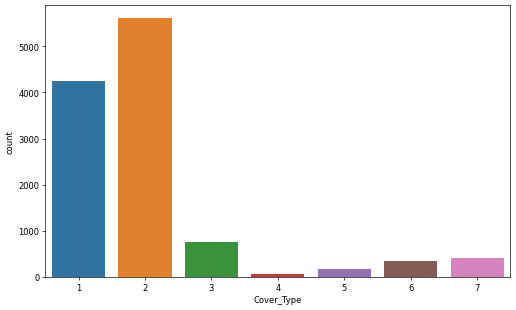

In [11]:
figure(figsize=(10, 6), dpi=60)
sns.countplot(x="Cover_Type", data=forest)

In [12]:
forest.isna().sum()

Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area1                      0
Wilderness_Area2                      0
Wilderness_Area3                      0
Wilderness_Area4                      0
Soil_Type1                            0
Soil_Type2                            0
Soil_Type3                            0
Soil_Type4                            0
Soil_Type5                            0
Soil_Type6                            0
Soil_Type7                            0
Soil_Type8                            0
Soil_Type9                            0
Soil_Type10                           0
Soil_Type11                           0


In [13]:
cv_train,cv_test = multi_class_adaboost(forest,k_folds=5,T_rounds=[50,150,250,350,450],
                               labelset='Cover_Type',random_state=50)

Cv for 50 rounds is completed
Cv for 150 rounds is completed
Cv for 250 rounds is completed
Cv for 350 rounds is completed
Cv for 450 rounds is completed


In [14]:
np.mean(cv_test,axis=1)

matrix([[0.70718475],
        [0.71417718],
        [0.71428471],
        [0.71471528],
        [0.71568348]])

In [15]:
np.mean(cv_train,axis=1)

matrix([[0.7156572 ],
        [0.72870045],
        [0.73308404],
        [0.73585404],
        [0.73819376]])

In [16]:
adaboost_round = 150

X_train,x_test,Y_train,y_test = split_train_test(data,test_size=0.2,label_col='Cover_Type',random_state=50)
train_preds= np.mat(np.ones(shape=(np.shape(X_train)[0],len(np.unique(data['Cover_Type'])))))
test_preds =  np.mat(np.ones(shape=(np.shape(x_test)[0],len(np.unique(data['Cover_Type'])))))
for classes in range(len(np.unique(data['Cover_Type']))): # one VS Rest classifier
    model,pred = adaboost_training(X_train,np.mat(np.where(Y_train==int(classes)+1,1,-1)),adaboost_round)
    train_preds[:,classes]=np.multiply(train_preds[:,classes],pred)
    test_est = adaboost_classifier(x_test,model)
    test_preds[:,classes]=np.multiply(test_preds[:,classes],test_est)

train_predictions = np.argmax(train_preds,axis=1)+1 # because indexing starts from 0
training_error = np.where(train_predictions != np.mat(Y_train).T,1,0).sum()
test_prediction = np.argmax(test_preds,axis=1)+1
test_error = np.where(test_prediction != np.mat(y_test).T,1,0).sum()
print('test accuracy:',1-(test_error/len(x_test)))
print('training accuracy:',1-(training_error/len(X_train)))

test accuracy: 0.713855421686747
training accuracy: 0.7270869191049913


In [17]:
cv_test

matrix([[0.71774194, 0.69553523, 0.69661108, 0.71382464, 0.71221087],
        [0.72311828, 0.70306616, 0.70683163, 0.72027972, 0.7175901 ],
        [0.72365591, 0.70521786, 0.70414201, 0.72189349, 0.71651425],
        [0.72150538, 0.70952125, 0.70252824, 0.72027972, 0.7197418 ],
        [0.72204301, 0.71005917, 0.70252824, 0.72512103, 0.71866595]])

In [18]:
np.mean(cv_test,axis=1)-np.std(cv_test,axis=1)

matrix([[0.69792929],
        [0.70635102],
        [0.70609   ],
        [0.70726093],
        [0.70739977]])

In [19]:
model # decision_stumps

[{'alpha': 1.6669943159843523, 'dimension': 48, 'ineq': 'below', 'split': 0.0},
 {'alpha': 1.0171827848085895,
  'dimension': 0,
  'ineq': 'below',
  'split': 3195.0},
 {'alpha': 0.5433751570234273, 'dimension': 52, 'ineq': 'below', 'split': 0.0},
 {'alpha': 0.3459692636534664,
  'dimension': 0,
  'ineq': 'below',
  'split': 3272.0},
 {'alpha': 0.2223044053290093,
  'dimension': 0,
  'ineq': 'below',
  'split': 3118.0},
 {'alpha': 0.3213263401591887, 'dimension': 51, 'ineq': 'below', 'split': 0.0},
 {'alpha': 0.20292749029754728,
  'dimension': 3,
  'ineq': 'above',
  'split': 157.8},
 {'alpha': 0.2420449003806774,
  'dimension': 0,
  'ineq': 'below',
  'split': 3118.0},
 {'alpha': 0.2449745741148934, 'dimension': 53, 'ineq': 'below', 'split': 0.0},
 {'alpha': 0.2218284549745989, 'dimension': 11, 'ineq': 'above', 'split': 0.0},
 {'alpha': 0.20601099100994955,
  'dimension': 0,
  'ineq': 'above',
  'split': 3195.0},
 {'alpha': 0.18497069536917474,
  'dimension': 0,
  'ineq': 'below',
  

Text(0, 0.5, 'Accuracy')

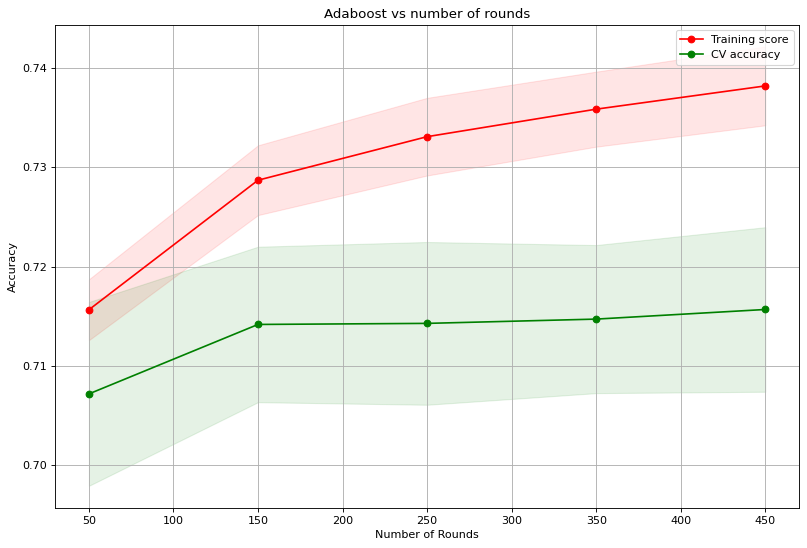

In [20]:
train_score_mean = np.mean(np.array(cv_train),axis=1)
train_score_std = np.std(np.array(cv_train),axis=1)
test_score_mean = np.mean(np.array(cv_test),axis=1)
test_score_std = np.std(np.array(cv_test),axis=1)
T_rounds = np.array([50,150,250,350,450])
plt.figure(figsize=(12, 8), dpi=80)
plt.title('Adaboost vs number of rounds')
plt.grid()
plt.fill_between(T_rounds, train_score_mean - train_score_std,
                 train_score_mean + train_score_std, alpha=0.1,
                 color="r")
plt.fill_between(T_rounds, test_score_mean - test_score_std,
                 test_score_mean + test_score_std, alpha=0.1, color="g")
plt.plot(T_rounds, train_score_mean, 'o-', color="r",
         label="Training score")
plt.plot(T_rounds, test_score_mean, 'o-', color="g",
         label="CV accuracy")
plt.legend()
plt.xlabel('Number of Rounds')
plt.ylabel('Accuracy')